In [174]:
import pandas as pd
import numpy  as np
import seaborn as sns
#sns.set(font_scale=1.5)
sns.set_context("poster")
%pylab inline
FS  = (16, 9)
FSS = (16, 5)

Populating the interactive namespace from numpy and matplotlib


<br/><br/><br/>

## Load the data

In [193]:
dp   = lambda date: pd.datetime.strptime(date, '%d%b%Y')
 
data = pd.read_csv('Example Stocks.csv', parse_dates=['date'], date_parser=dp)

data.columns = list( map( lambda x : x.lower(), data.columns ) )

class Stock:
    def __init__(self, name, permno, color):
        self.permno = permno
        self.name   = name
        self.color  = color
        self.mask   = (data['permno']==permno)

CocaCola     = Stock('Coca-Cola',     11308, sns.xkcd_rgb['red' ]  )
Apple        = Stock('Apple',         14593, sns.xkcd_rgb['denim blue'] )
PhilipMorris = Stock('Philip Morris', 92602, sns.xkcd_rgb['dark grey'] )
Tesla        = Stock('Tesla',         93436, sns.xkcd_rgb['teal'] )

In [194]:
def plot_returns(stocks):
    
    if type(stocks) == Stock:
        stocks = [stocks]

    fig, ax1 = plt.subplots(1,1, figsize=FS)
    
    for stock in stocks:
        df = data[stock.mask]
        df.plot(
            y='ret', x='date', style=':', marker='o', 
            label=stock.name+' monthly returns', 
            ax=ax1, color= stock.color
               )
        
    legend = plt.legend(frameon=True, loc=0)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    plt.ylim([-0.3,0.3])
    #ax1.axhline(0, linestyle=':', color='grey')

<br/><br/><br/>

## Returns

$$ R_t = \frac{p_{t}-p_{t-1}}{p_{t-1}} = \frac{p_{t}}{p_{t-1}} - 1 $$

Usually, we consider dividends as well

$$ R_t = \frac{p_{t}+d_{t}}{p_{t-1}} - 1 $$

## Historical returns data
As an example, I downloaded historical returns of 4 well-known companies quoted in the US equity market, from 2011 to 2015.

Let's see what we have:

In [195]:
data.groupby('company').head(2)[['company', 'date', 'prc', 'ret']]

,company,date,prc,ret
0,COCA COLA,2011-01-31,62.85000,-0.044397
1,COCA COLA,2011-02-28,63.92000,0.017025
60,APPLE,2011-01-31,339.32001,0.051959
61,APPLE,2011-02-28,353.20999,0.040935
120,PHILIP MORRIS,2011-01-31,57.24000,-0.022040
121,PHILIP MORRIS,2011-02-28,62.78000,0.096785
180,TESLA MOTORS,2011-01-31,24.10000,-0.095006
181,TESLA MOTORS,2011-02-28,23.89000,-0.008714


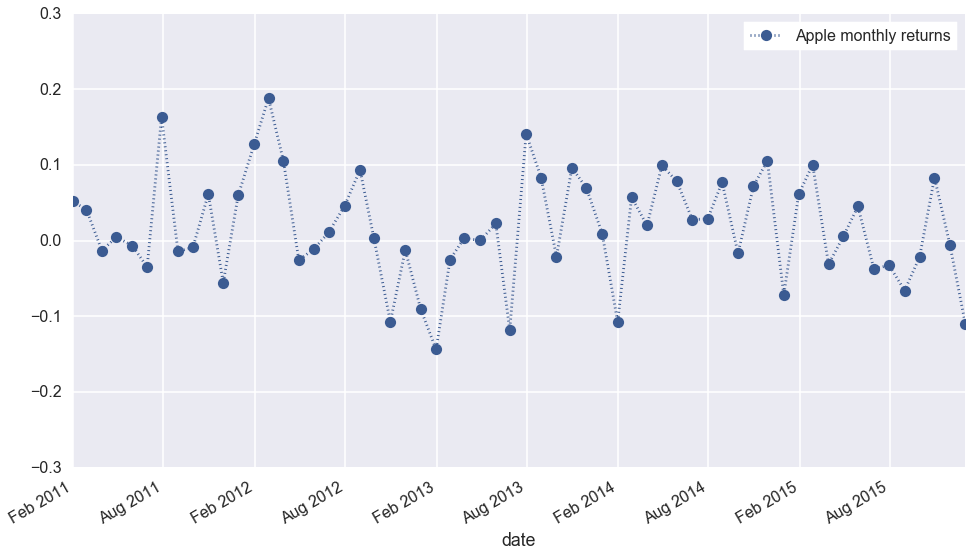

In [213]:
plot_returns( Apple )

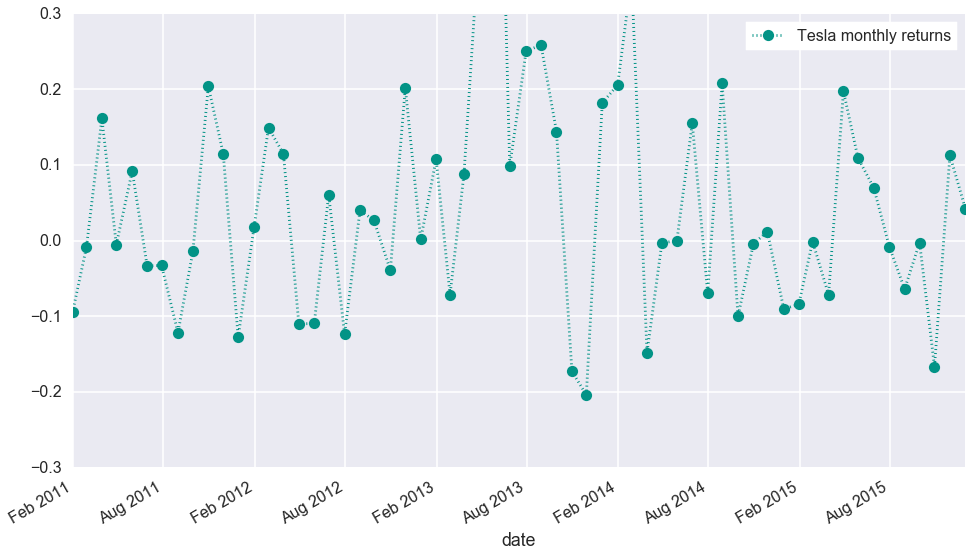

In [197]:
plot_returns( Tesla )

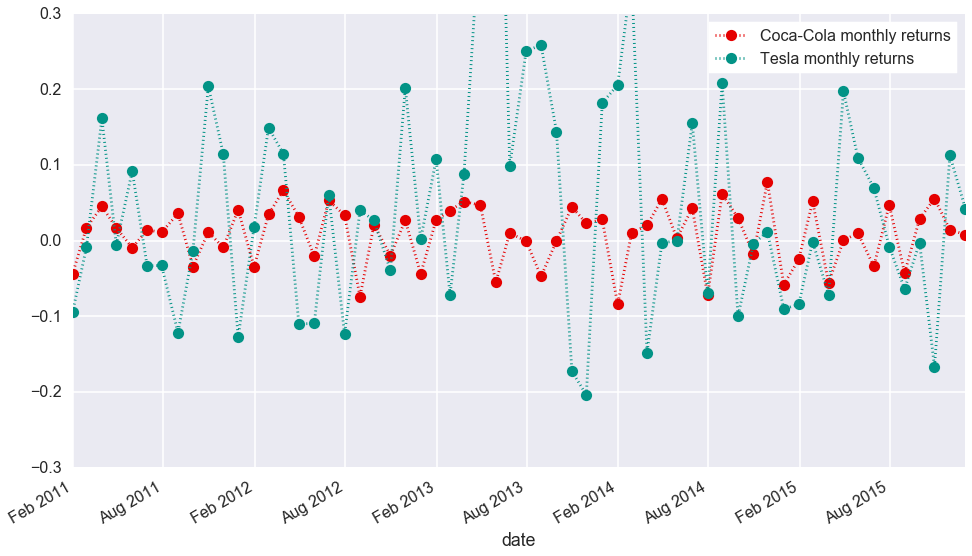

In [200]:
plot_returns( [ CocaCola  ,  Tesla  ] )

<br/><br/><br/>

## Expectation
The **expected value** of a random variable $X$ is defined as

$$ E(X) = \sum x \cdot P(x) $$

where the sum runs over all the possible values that $X$ can take, while $P(x)$ denotes the probability that $X$ takes the values $x$.

## Sample Average
Suppose we have a sample of $n$ realizations $\{ x_1, \dots, x_n \}$ of a random variable $X$. The empirical counterpart of the expectation operator is the **sample average**, defined as

$$ \hat{E}(X) = \frac{1}{n}\sum_{i=1}^n x_i $$

Basically, we are assuming that our sample is drawn from a uniform distribution, meaning that $P(x)=\frac{1}{n}$ for every realized value $x$.

## Expected Return
In the case of stock returns, we don't know their probability distributions. But we have realizations from historical data, so we can compute the sample average, or **mean**

In [71]:
data.groupby('company')['ret'].mean().to_frame()

,ret
company,
APPLE,0.017509
COCA COLA,0.007645
PHILIP MORRIS,0.011852
TESLA MOTORS,0.048767


In [72]:
df = data[Tesla]
n  = len(df)
df['ret'].sum() / n

0.04876661666666667

<br/><br/><br/>

## Standard Deviation

In [203]:
data.set_index('company', inplace=1)
data['ER'] = ER
data.reset_index(inplace=1)
data['deviation'] = data['ret'] - data['ER']

In [204]:
def plot_cumulative(stocks):
    if type(stocks) == Stock:
        stocks = [stocks]
    fig, (ax1) = plt.subplots(1,1, figsize=FS)
    for stock in stocks:
        df = data[stock.mask].set_index('date')
        df['ret'].cumsum().plot(ax=ax1, label=stock.name +' Cumulative Return', color=stock.color)
        df['ER' ].cumsum().plot(ax=ax1, label=stock.name +' Expected Cumulative Return', style=':', color=stock.color)
    #ax1.set_ylim([-0.5, 3.5])

    legend = plt.legend(frameon=True, loc=2)
    frame = legend.get_frame()
    frame.set_facecolor('white')

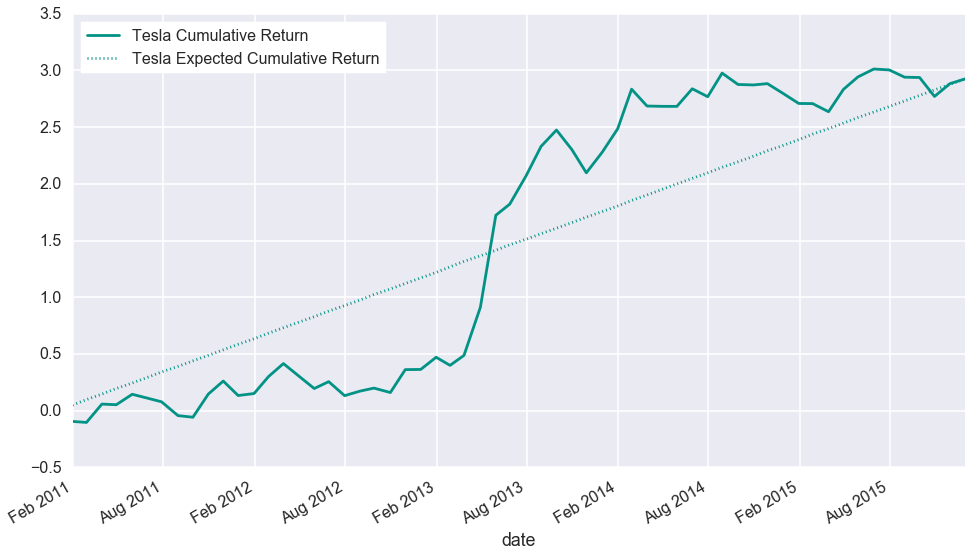

In [205]:
plot_cumulative( Tesla )

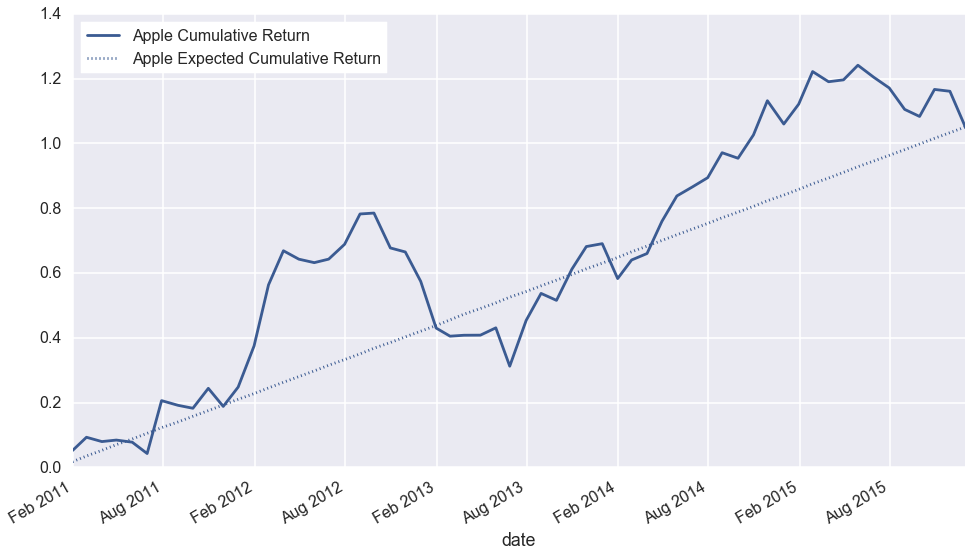

In [206]:
plot_cumulative( Apple )

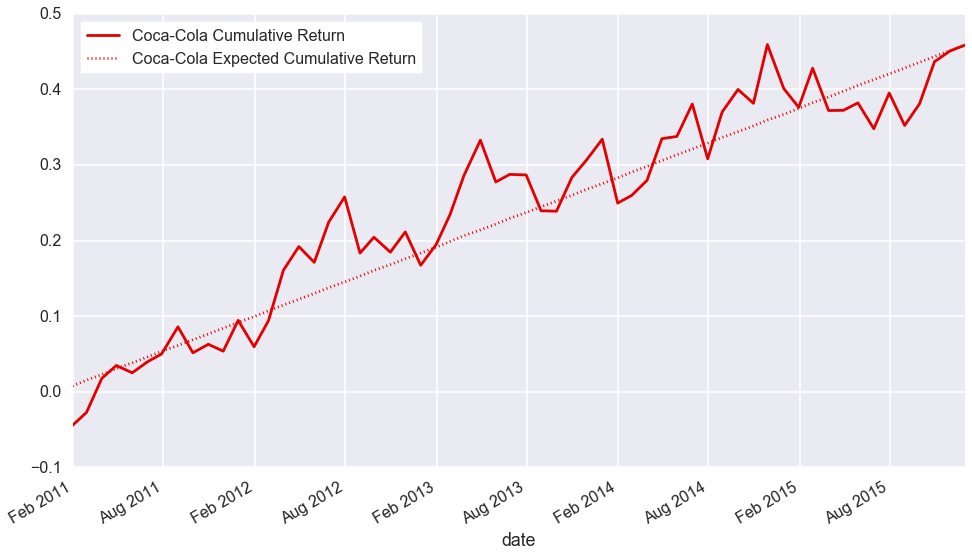

In [207]:
plot_cumulative( CocaCola )

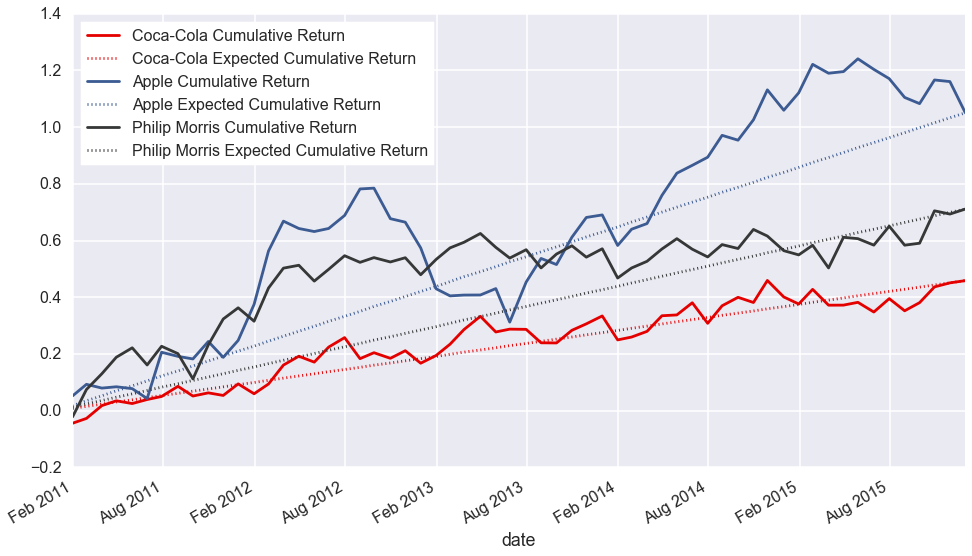

In [212]:
plot_cumulative([CocaCola, Apple, PhilipMorris] )

<br/><br/><br/>

## Expected Return VS Volatility

In [209]:
ER = data.groupby('company')['ret'].mean()
SD = data.groupby('company')['ret'].std()

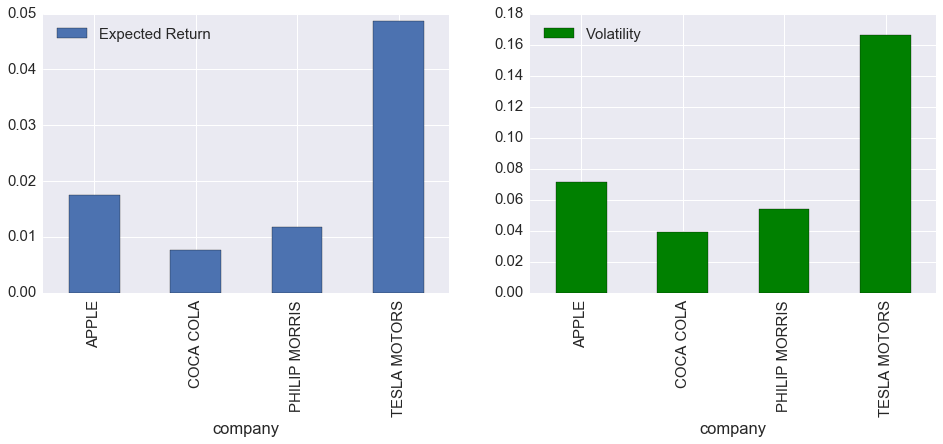

In [80]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=FSS)
ER.plot( kind='bar', ax=ax1, label='Expected Return' )
SD.plot( kind='bar', ax=ax2, label='Volatility', color='g' )
_ = ax1.legend(loc=0); _ = ax2.legend(loc=0)

<br/><br/><br/>

import matplotlib.gridspec as gridspec

fig, (ax1, space, ax2) = plt.subplots(3,1, gridspec_kw = {'height_ratios':[10,3,5]})

fig.figsize=(16, 15)

df = data[Tesla]

df.plot(y='ret', x='date', style='o', label='Monthly returns' , ax=ax1)
df.plot(y='deviation', x='date', kind='bar', figsize=FSS, ax=ax2, label='Deviation from the mean')

ax1.axhline( df['ER'].iloc[0], color='grey' )

ax1   .set_ylim([-0.4,0.4])
space .set_axis_off()
ax2   .set_axis_off()